## **Week 4: From MLPs to Convolutional Neural Networks**
### José Manuel López, Alex Martín, Marcos V. Conde

#### <ins>Understanding Layer Manipulation</ins>
1. Check existing architectures
2. Set a new model from an existing architecture
3. Apply model to a small dataset

#### <ins>Deal with dataset loading</ins>
4. Introduce and evaluate Data Augmentation Impact

#### <ins>Hyperparametrs optimization</ins>
4. Introduce and evaluate the usage of dropout, batch normalization, ...
5. Apply random search on model hyperparametes

In [11]:
from tensorflow.python.util import deprecation
import tensorflow as tf
from tensorflow.keras.mixed_precision import experimental as mixed_precision
import warnings
import os

Tensorflow allocates all VRAM without this.
Additionally we want to enable mixed precision aka use TensorCores if our GPU is capable to speedup the computation.

In [12]:
# Disable Warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# VRAM broke without this
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.config.experimental_run_functions_eagerly(True)

try:
    # Change to TF16 mixed precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy)
except:
    pass

print(gpus[0])
print(tf.__version__)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
2.6.0


### Loading Datasets

We are going to define variables related to dataset and load data into generators

In [13]:
from keras.preprocessing.image import ImageDataGenerator

In [14]:
IMG_SIZE = 224
BATCH_SIZE = 64
RANDOM_SEED = 42
CLASSES = ['coast','forest','highway','inside_city','mountain','Opencountry','street','tallbuilding']
def get_dataset(path):
    print("Loading: {}".format(path))
    train_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)

    train_loader = train_datagen.flow_from_directory(
                path+'/train',  
                target_size=(IMG_SIZE, IMG_SIZE), 
                batch_size=BATCH_SIZE,
                classes = CLASSES,
                class_mode='categorical') 

    test_loader = test_datagen.flow_from_directory(
            path+'/test',
            target_size=(IMG_SIZE, IMG_SIZE),
            batch_size=BATCH_SIZE,
            classes = CLASSES,
            class_mode='categorical')
    

    examples = enumerate(test_loader)
    batch_idx, (example_data, example_targets) = next(examples)
    print("Data Shape: {}".format(example_data.shape))
    print("---"*30)

    return train_loader, test_loader

In [15]:

DATA_DIR = "./MIT_small_train_{}"

# Dataset 1
train_loader_1, test_loader_1 = get_dataset(DATA_DIR.format(1))
# Dataset 2
train_loader_2, test_loader_2 = get_dataset(DATA_DIR.format(2))
# Dataset 3
train_loader_3, test_loader_3 = get_dataset(DATA_DIR.format(3))
# Dataset 4
train_loader_4, test_loader_4 = get_dataset(DATA_DIR.format(4))


Loading: ./MIT_small_train_1
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (64, 224, 224, 3)
------------------------------------------------------------------------------------------
Loading: ./MIT_small_train_2
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (64, 224, 224, 3)
------------------------------------------------------------------------------------------
Loading: ./MIT_small_train_3
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (64, 224, 224, 3)
------------------------------------------------------------------------------------------
Loading: ./MIT_small_train_4
Found 400 images belonging to 8 classes.
Found 2288 images belonging to 8 classes.
Data Shape: (64, 224, 224, 3)
------------------------------------------------------------------------------------------


## Check existing architectures: ResNet50
We are going to try ResNet50 pretrained on ImageNet and evaluate the performance of the model.

In [16]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt


N: 35
Predicted: [('n03729826', 'matchstick', 0.06146), ('n06359193', 'web_site', 0.04242), ('n01930112', 'nematode', 0.03128)]
Real: inside_city


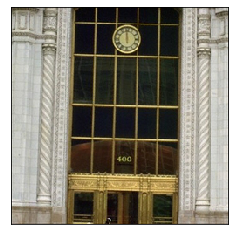

In [17]:
examples = enumerate(train_loader_1)
batch_idx, (example_data, example_targets) = next(examples)
n = np.random.randint(low = 0, high = len(example_data)+1, size=1)[0]

print("N: {}".format(n))

x = preprocess_input(example_data)
model = ResNet50V2(weights='imagenet')
preds = model.predict(x)

examples = enumerate(train_loader_1)
batch_idx, (example_data, example_targets) = next(examples)

print('Predicted:', decode_predictions(preds, top=3)[n])
print('Real:', CLASSES[np.argmax(example_targets[n])])

plt.imshow(example_data[n], cmap='gray', interpolation='none')
plt.xticks([])
plt.yticks([])
plt.show()

## Set a new model from an existing architecture
Now we are we are going to use ResNet50's skeleton and use those features to build our classifier. We will add the FC layers and perform the classification.

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [19]:
def plot_loss_accuracy(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25,8))
    
    fig.suptitle(title, fontsize=16)

    # Plot history: CrossEntropy
    ax1.plot(history.history['loss'], label='CrossEntropy (training data)')
    ax1.plot(history.history['val_loss'], label='CrossEntropy (validation data)')
    ax1.set_title('Loss Function: Cross Entropy')
    ax1.set(xlabel='Epoch', ylabel='Loss Value')
    ax1.legend(loc="upper left")

    # Plot history: Accuracy
    ax2.plot(history.history['accuracy'], label='Accuracy (training data)')
    ax2.plot(history.history['val_accuracy'], label='Accuracy (validation data)')
    ax2.set_title('Accuracy')
    ax2.set(xlabel='Epoch', ylabel='Accuracy Value')
    ax2.legend(loc="upper left")

    plt.show()

In [20]:
def buil_custom_resnet50(layers):
    # ResNet Base Model
    base_model = ResNet50V2(weights='imagenet', include_top=False)
    x = base_model.output
    # We Flatten with GlobalAveragePooling2D()
    x = GlobalAveragePooling2D()(x)

    # Flattened features to FCs
    for layer in layers:
        x = layer(x)

    # Perform classification
    predictions = Dense(len(CLASSES), activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    # We don't want to modify imagenet weights
    for layer in base_model.layers:
        layer.trainable = False

    # Compile model
    opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
    opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)
    model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=["accuracy"])

    return model

# Training on different datasets
# Dataset 1
model = buil_custom_resnet50(layers=[Dense(1024, activation='relu')])
history_1 = model.fit(train_loader_1,steps_per_epoch=400 // BATCH_SIZE, epochs=5, validation_data=test_loader_1, validation_steps=2288 // BATCH_SIZE)
# Dataset 2
model = buil_custom_resnet50(layers=[Dense(1024, activation='relu')])
history_2 = model.fit(train_loader_2,steps_per_epoch=400 // BATCH_SIZE, epochs=5, validation_data=test_loader_2, validation_steps=2288 // BATCH_SIZE)
# Dataset 3
model = buil_custom_resnet50(layers=[Dense(1024, activation='relu')])
history_3 = model.fit(train_loader_3,steps_per_epoch=400 // BATCH_SIZE, epochs=5, validation_data=test_loader_3, validation_steps=2288 // BATCH_SIZE)
# Dataset 4
model = buil_custom_resnet50(layers=[Dense(1024, activation='relu')])
history_4 = model.fit(train_loader_4,steps_per_epoch=400 // BATCH_SIZE, epochs=5, validation_data=test_loader_4, validation_steps=2288 // BATCH_SIZE)

Epoch 1/5
6/6 [==============================] - 6s 1s/step - loss: 0.8079 - accuracy: 0.7292 - val_loss: 0.3545 - val_accuracy: 0.8777
Epoch 2/5
6/6 [==============================] - 7s 1s/step - loss: 0.1348 - accuracy: 0.9479 - val_loss: 0.2985 - val_accuracy: 0.9027
Epoch 3/5
6/6 [==============================] - 7s 1s/step - loss: 0.0761 - accuracy: 0.9881 - val_loss: 0.3499 - val_accuracy: 0.8938
Epoch 4/5
6/6 [==============================] - 7s 1s/step - loss: 0.0257 - accuracy: 0.9881 - val_loss: 0.3047 - val_accuracy: 0.9107
Epoch 5/5
6/6 [==============================] - 6s 1s/step - loss: 0.0123 - accuracy: 0.9974 - val_loss: 0.3228 - val_accuracy: 0.9103
Epoch 1/5
6/6 [==============================] - 7s 1s/step - loss: 1.0487 - accuracy: 0.6016 - val_loss: 0.3640 - val_accuracy: 0.8772
Epoch 2/5
6/6 [==============================] - 6s 1s/step - loss: 0.1655 - accuracy: 0.9464 - val_loss: 0.2731 - val_accuracy: 0.9089
Epoch 3/5
6/6 [==============================] -

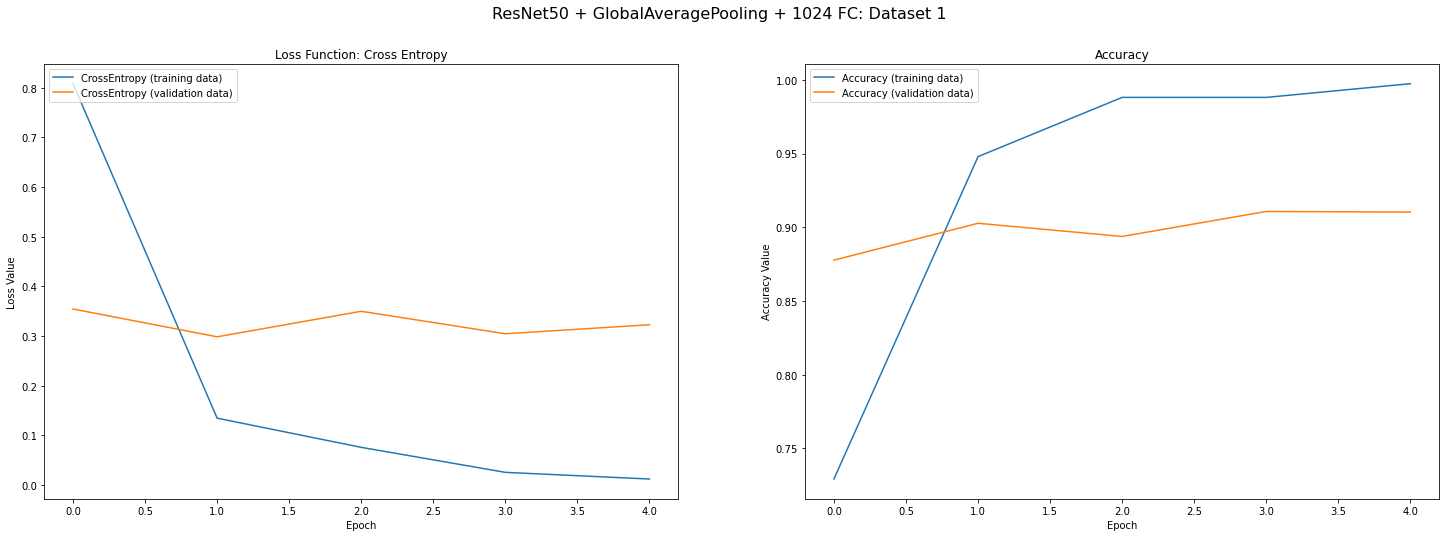

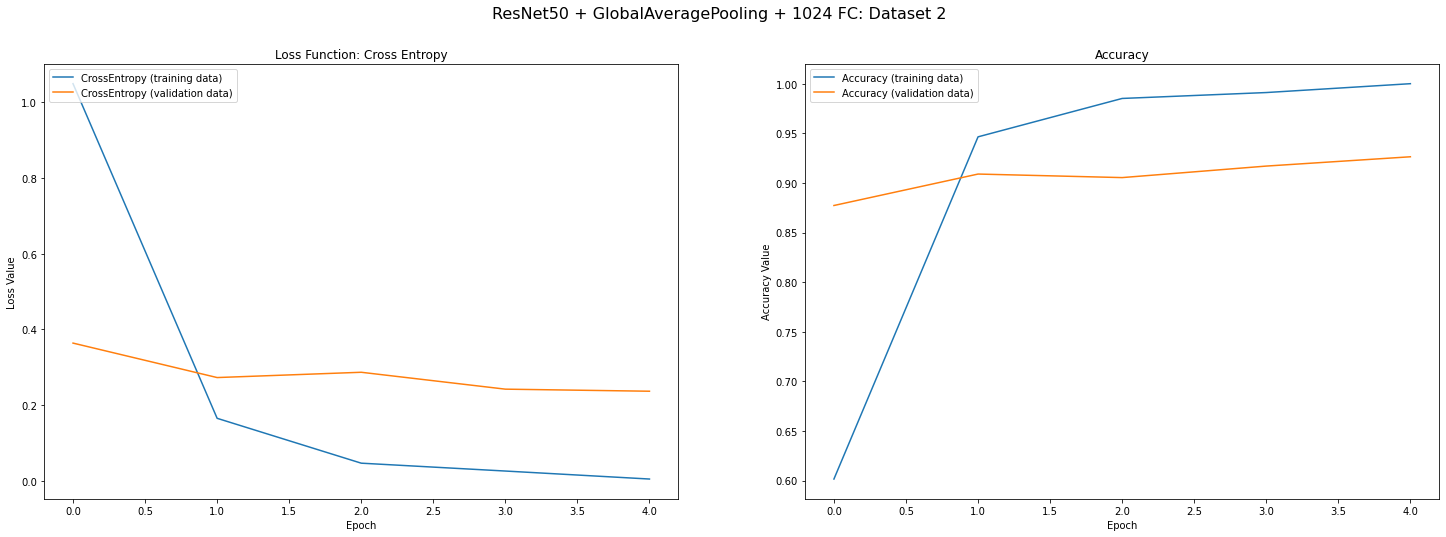

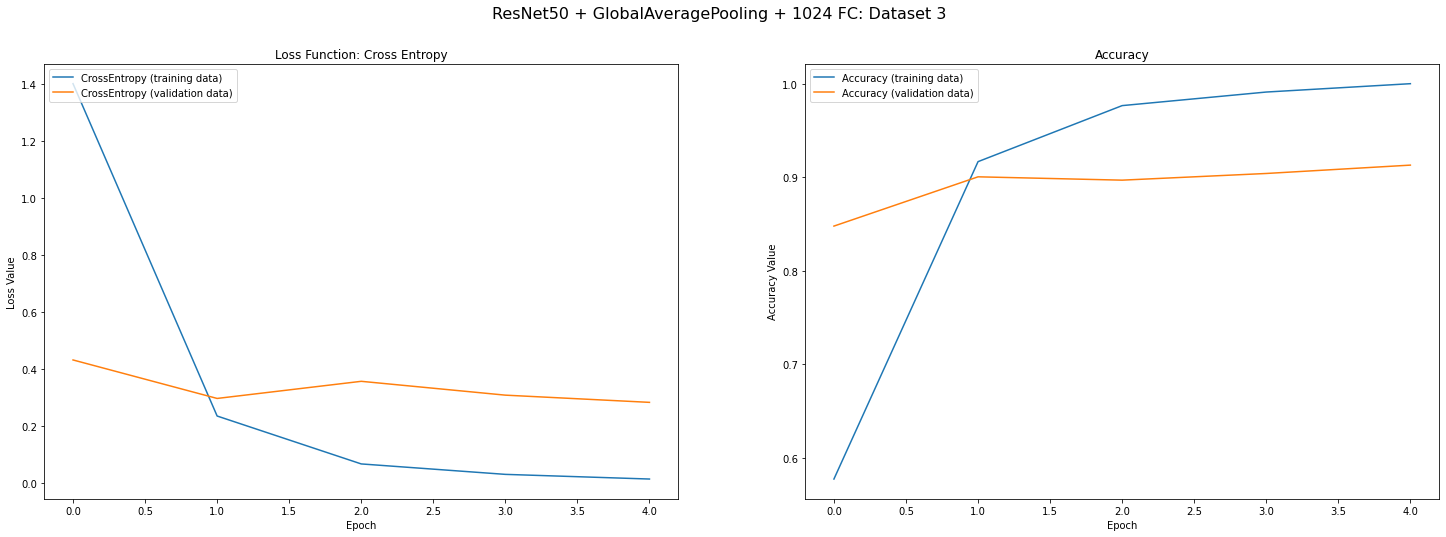

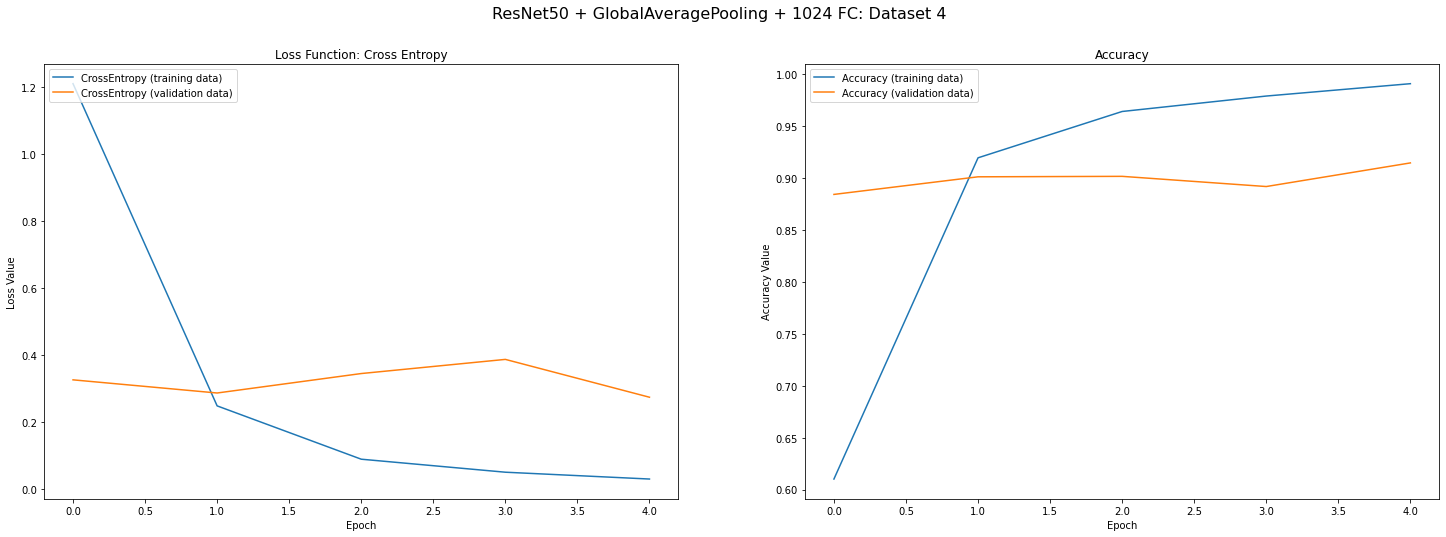

In [21]:
plot_loss_accuracy(history_1, 'ResNet50 + GlobalAveragePooling + 1024 FC: Dataset 1')
plot_loss_accuracy(history_2,  'ResNet50 + GlobalAveragePooling + 1024 FC: Dataset 2')
plot_loss_accuracy(history_3,  'ResNet50 + GlobalAveragePooling + 1024 FC: Dataset 3')
plot_loss_accuracy(history_4,  'ResNet50 + GlobalAveragePooling + 1024 FC: Dataset 4')

We observe how ResNet50 + GlobalAveragePooling + 1024 FC outperforms our best MLP model that was around 60% accuracy by a big margin (100% train and 90-93% for test). CNNs show their power when it comes to images.